In [1]:
import sys
sys.path.append("..")
import os

from dacludek.model import DaCluDeK

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score

In [2]:
defined_keywords = {}
documents_df = pd.read_csv('../../datasets/data/BBC_News/documents.csv')
documents = documents_df['document'].tolist()
labels = documents_df['class_name'].tolist()

doc2vec_model = DaCluDeK(defined_keywords=defined_keywords, train_documents=documents, embedding_model_name='Doc2Vec', verbose=True, save_cache=True, load_cache=True, doc2vec_n_spacy_keywords=20, dimensionality_reduction_n_components=2)
doc2vec_model.load_embeddings_model()

# Embeddings

In [9]:
def plot_embeddings_2d(documents_df: pd.DataFrame):
    """ Plot embeddings in a 2D space

    Args:
        documents_df (pd.DataFrame): DataFrame with the documents and their labels
    """
    documents = documents_df['document'].tolist()

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle('Embeddings 2D', fontsize=20, fontweight='bold')
    fig.tight_layout(pad=5.0, rect=[-0.01, -0.03, 1.03, 1.07])

    # -- Doc2Vec
    doc2vec_model = DaCluDeK(defined_keywords=defined_keywords, train_documents=documents, embedding_model_name='Doc2Vec', verbose=True, save_cache=True, load_cache=True, doc2vec_n_spacy_keywords=20, dimensionality_reduction_n_components=2)
    doc2vec_model.load_embeddings_model()

    doc2vec_embeddings = doc2vec_model.encode_documents(documents)
    doc2vec_embeddings_df = pd.DataFrame(doc2vec_embeddings, columns=['x', 'y'])
    doc2vec_embeddings_df['Class'] = documents_df['class_name']

    sns.kdeplot(x='x', y='y', data=doc2vec_embeddings_df, ax=ax[0], hue='Class', levels=5, fill=True, alpha=0.5, palette='viridis')
    sns.scatterplot(x='x', y='y', hue='Class', data=doc2vec_embeddings_df, ax=ax[0], palette='viridis')

    ax[0].set_title('Doc2Vec', fontsize=16, fontweight='bold')

    # -- SentenceTransformer
    sentence_transformer_model = DaCluDeK(defined_keywords=defined_keywords, train_documents=documents, embedding_model_name='SentenceTransformer', verbose=True, dimensionality_reduction_model_name='PCA', dimensionality_reduction_n_components=2)
    sentence_transformer_model.load_embeddings_model()

    sentence_transformer_embeddings = sentence_transformer_model.encode_documents(documents)
    sentence_transformer_embeddings_df = pd.DataFrame(sentence_transformer_embeddings, columns=['x', 'y'])
    sentence_transformer_embeddings_df['Class'] = documents_df['class_name']

    sns.kdeplot(x='x', y='y', data=sentence_transformer_embeddings_df, ax=ax[1], hue='Class', levels=5, fill=True, alpha=0.5, palette='viridis')
    sns.scatterplot(x='x', y='y', hue='Class', data=sentence_transformer_embeddings_df, ax=ax[1], palette='viridis')

    ax[1].set_title('SentenceTransformer', fontsize=16, fontweight='bold')

    fig.savefig('../../figures/dacludek/embeddings_2d.png')

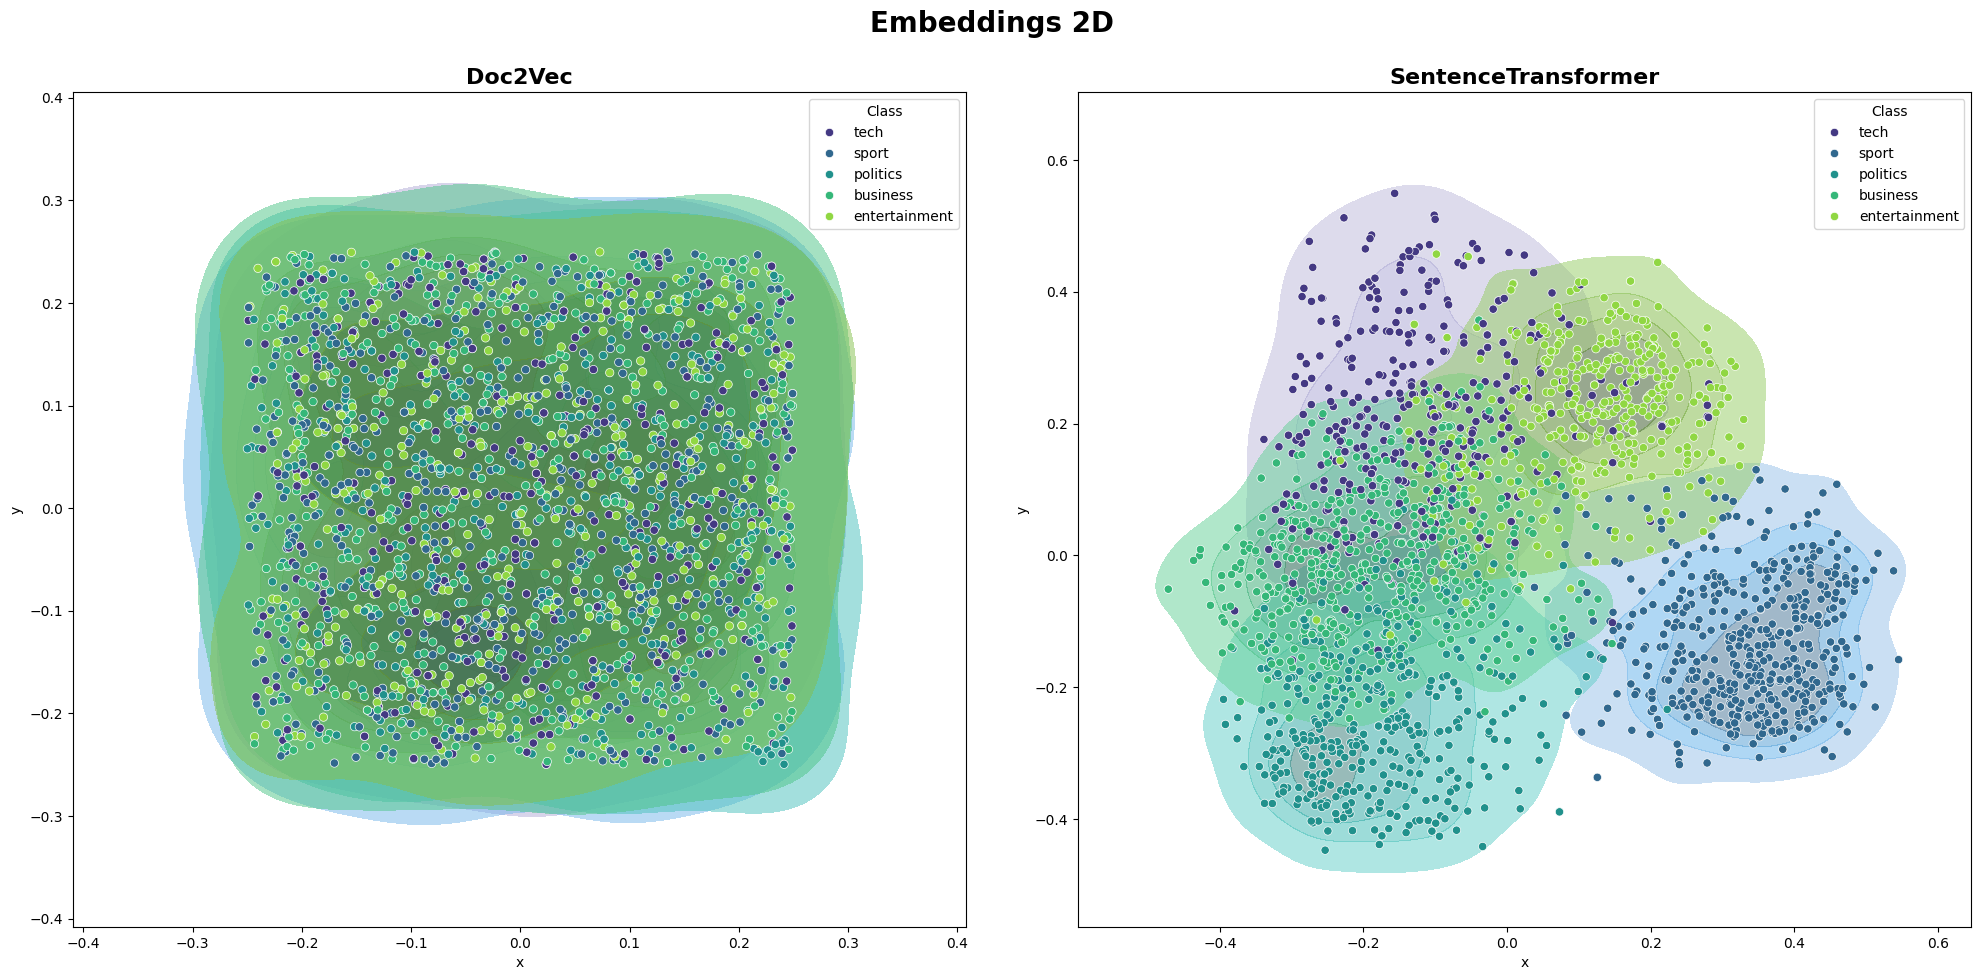

In [10]:
plot_embeddings_2d(documents_df)

# Performances

## Performances using most frequent words

In [11]:
documents_df = pd.read_csv('../../datasets/data/BBC_News/documents.csv')
documents = documents_df['document'].tolist()
labels = documents_df['class_name'].tolist()

def get_n_most_frequent_keywords_by_class(n: int):
    """ Get the n most frequent keywords by class
    
    Args:
        n (int): Number of keywords to return

    Returns:
        dict: Dictionary with the n most frequent keywords by class
    """
    most_frequent_keywords = {}
    for class_name in documents_df['class_name'].unique():
        count_words_by_class = {}
        for words in documents_df[documents_df['class_name'] == class_name]['document']:
            for word in words.split():
                if word not in count_words_by_class:
                    count_words_by_class[word] = 0
                count_words_by_class[word] += 1

        most_frequent_keywords[class_name] = []
        for word, count in sorted(count_words_by_class.items(), key=lambda item: item[1], reverse=True)[:20]:
            most_frequent_keywords[class_name].append(word)

    for class_name in most_frequent_keywords.keys():
        most_frequent_keywords[class_name] = most_frequent_keywords[class_name][:n]

    return most_frequent_keywords

In [12]:
most_frequent_keywords = get_n_most_frequent_keywords_by_class(5)

In [13]:
def display_keywords_as_df(keywords_by_class: dict):
    """ Display keywords by class as a DataFrame
    
    Args:
        keywords_by_class (dict): Dictionary with the keywords by class

    Returns:
        pd.DataFrame: DataFrame with the keywords by class
    """
    columns = sorted(keywords_by_class.keys())
    keywords_df = pd.DataFrame(columns=columns)

    for class_name in columns:
        keywords_df[class_name] = keywords_by_class[class_name]

    print(keywords_df.to_latex(index=False))
    return keywords_df

In [14]:
display_keywords_as_df(most_frequent_keywords)

\begin{tabular}{lllll}
\toprule
business & entertainment & politics & sport & tech \\
\midrule
company & film & government & win & game \\
firm & good & election & game & technology \\
market & award & party & play & phone \\
rise & music & labour & player & mobile \\
sale & show & plan & good & service \\
\bottomrule
\end{tabular}



,business,entertainment,politics,sport,tech
0,company,film,government,win,game
1,firm,good,election,game,technology
2,market,award,party,play,phone
3,rise,music,labour,player,mobile
4,sale,show,plan,good,service


In [15]:
def plot_performances_models(documents_df: pd.DataFrame, keywords_by_class: dict, description: str):
    """ Plot the performances of the models

    Args:
        documents_df (pd.DataFrame): DataFrame with the documents and their labels
        keywords_by_class (dict): Dictionary with the keywords by class
        description (str): Description of the experiment
    """
    train_docs = documents_df[documents_df['dataset_type'] == 'train']['document'].tolist()
    test_docs = documents_df[documents_df['dataset_type'] == 'test']['document'].tolist()

    train_labels = documents_df[documents_df['dataset_type'] == 'train']['class_name'].tolist()
    test_labels = documents_df[documents_df['dataset_type'] == 'test']['class_name'].tolist()

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    fig.suptitle(f'Performances ({description})', fontsize=20, fontweight='bold')
    fig.tight_layout(pad=5.0, rect=[-0.01, -0.03, 1.03, 1.07])

    # -- Doc2Vec
    doc2vec_model = DaCluDeK(defined_keywords=keywords_by_class, train_documents=documents, embedding_model_name='Doc2Vec', verbose=True, save_cache=True, load_cache=True, doc2vec_n_spacy_keywords=20)
    doc2vec_model.fit()

    y_pred_train = doc2vec_model.predict(train_docs)['class_name'].tolist()
    y_pred_test = doc2vec_model.predict(test_docs)['class_name'].tolist()

    f1_train = f1_score(train_labels, y_pred_train, average=None)
    f1_test = f1_score(test_labels, y_pred_test, average=None)

    result_df = pd.DataFrame({'Class': documents_df['class_name'].unique(), 'Train': f1_train, 'Test': f1_test})
    result_df = result_df.melt('Class', var_name='Dataset', value_name='F1 Score')

    sns.barplot(x='Class', y='F1 Score', hue='Dataset', data=result_df, ax=ax[0], palette='viridis')

    avg_train, avg_test = np.mean(f1_train), np.mean(f1_test)

    ax[0].set_title('Doc2Vec (Train: {:.2f} - Test: {:.2f})'.format(avg_train, avg_test), fontsize=16, fontweight='bold')
    ax[0].set_ylim(0, 1)

    # -- SentenceTransformer
    sentence_transformer_model = DaCluDeK(defined_keywords=keywords_by_class, train_documents=documents, embedding_model_name='SentenceTransformer', verbose=True)
    sentence_transformer_model.fit()

    y_pred_train = sentence_transformer_model.predict(train_docs)['class_name'].tolist()
    y_pred_test = sentence_transformer_model.predict(test_docs)['class_name'].tolist()

    f1_train = f1_score(train_labels, y_pred_train, average=None)
    f1_test = f1_score(test_labels, y_pred_test, average=None)

    result_df = pd.DataFrame({'Class': documents_df['class_name'].unique(), 'Train': f1_train, 'Test': f1_test})
    result_df = result_df.melt('Class', var_name='Dataset', value_name='F1 Score')

    sns.barplot(x='Class', y='F1 Score', hue='Dataset', data=result_df, ax=ax[1], palette='viridis')

    avg_train, avg_test = np.mean(f1_train), np.mean(f1_test)

    ax[1].set_title('SentenceTransformer (Train: {:.2f} - Test: {:.2f})'.format(avg_train, avg_test), fontsize=16, fontweight='bold')
    ax[1].set_ylim(0, 1)

    fig.savefig(f'../../figures/dacludek/performances_{description.replace(" ", "_")}.png')

/Users/yorest/miniconda3/envs/nlp/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


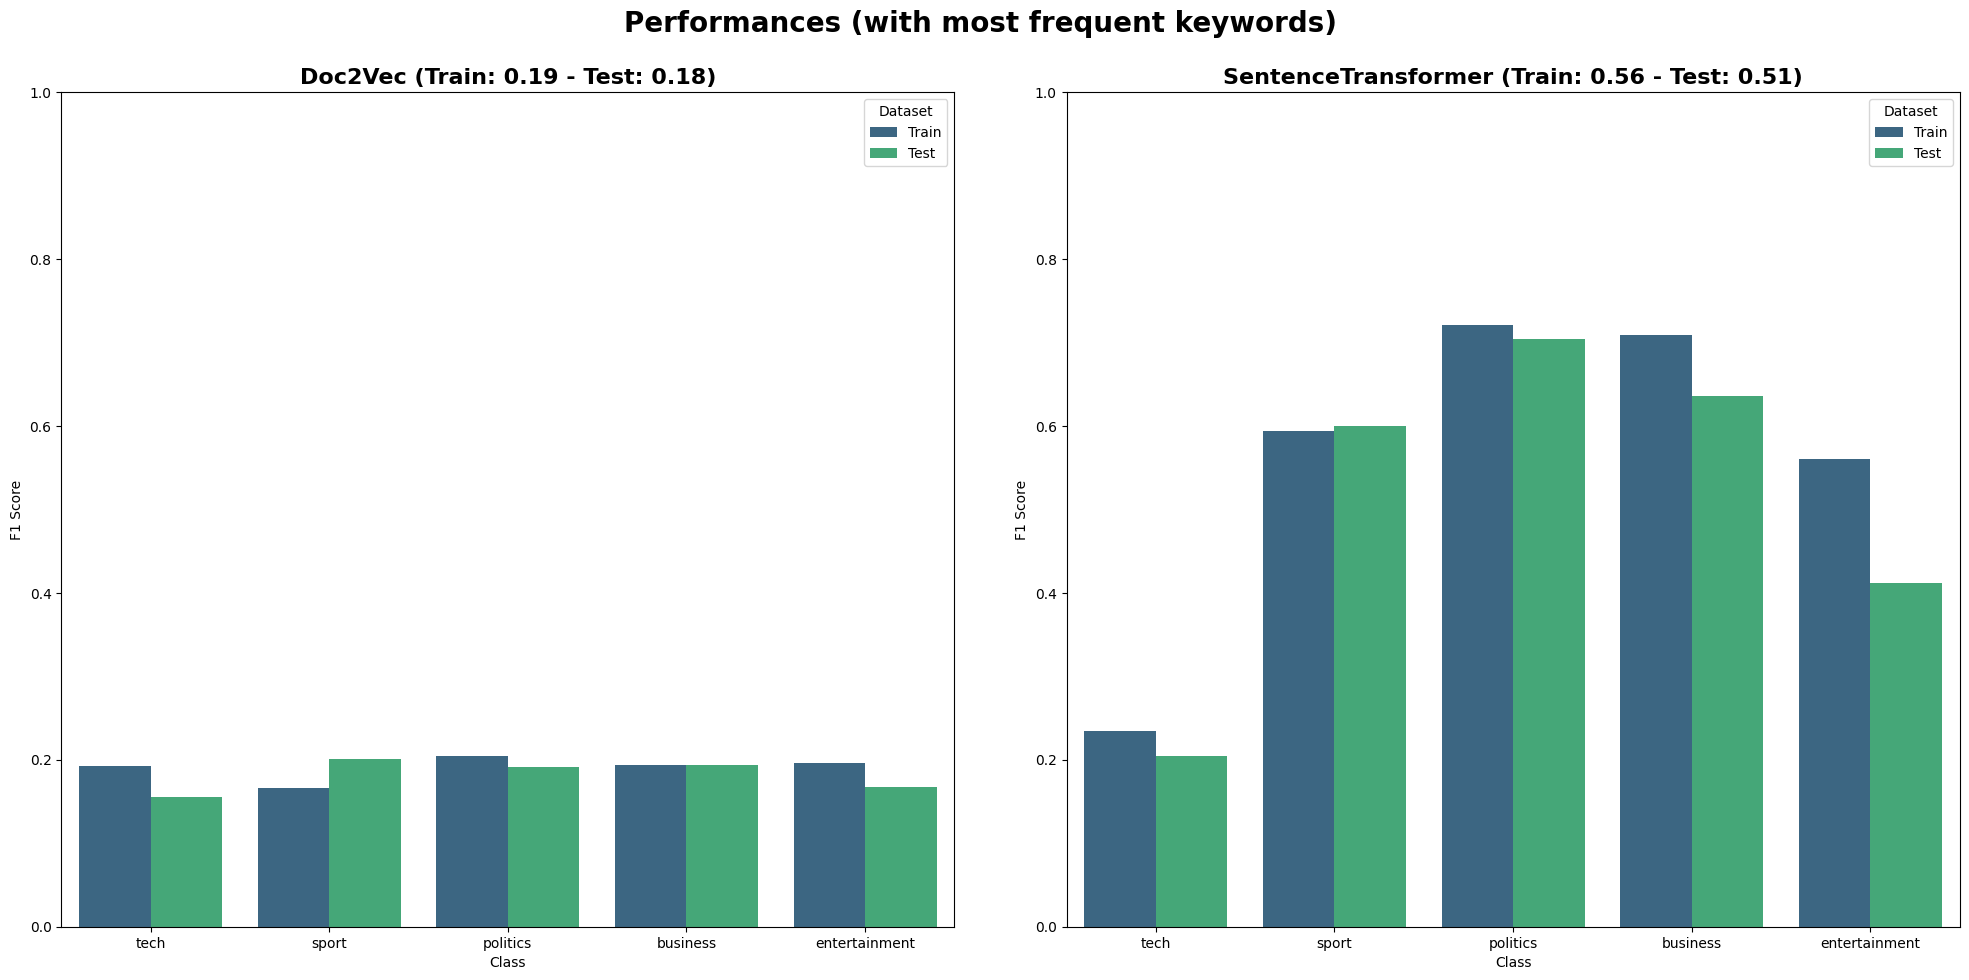

In [16]:
plot_performances_models(documents_df, most_frequent_keywords, description='with most frequent keywords')

# Performances using most similar word

In [17]:
def get_most_similar_keywords_by_class(n: int, documents_df: pd.DataFrame, labels_df: pd.DataFrame, load_cache: bool = True):
    """ Get the n most similar keywords to the defined keywords by class

    Args:
        n (int): Number of keywords to return
        documents_df (pd.DataFrame): DataFrame with the documents and their labels
        labels_df (pd.DataFrame): DataFrame with the defined keywords by class
        load_cache (bool, optional): Whether to load the cache or not. Defaults to True.
    
    Returns:
        dict: Dictionary with the n most similar keywords by class
    """
    keywords_by_class = {}

    train_docs = documents_df[documents_df['dataset_type'] == 'train']['document'].tolist()
    documents_repr = ''.join([item[0] for item in train_docs])[:10]

    if not load_cache:
        defined_keywords = {}
        for _, row in labels_df.iterrows():
            defined_keywords[row['class_name']] = row['class_keywords'].split(' ')

        inner_doc2vec_model = DaCluDeK(defined_keywords=defined_keywords, train_documents=train_docs, embedding_model_name='Doc2Vec', verbose=True, save_cache=True, doc2vec_n_spacy_keywords=20)
        inner_doc2vec_model.load_embeddings_model()

    keywords_df = pd.read_csv(f'../dacludek/cache/{documents_repr}_spacy_keywords.csv')
    
    for class_name in keywords_df['class_name'].unique():
        keywords_by_class[class_name] = keywords_df[keywords_df['class_name'] == class_name]['class_result_keywords'].apply(lambda x: x[1:-1].replace('\'', '').split(', ')).tolist()[0][:n]
    return keywords_by_class

In [18]:
documents_df = pd.read_csv('../../datasets/data/BBC_News/documents.csv')
labels_df = pd.read_csv('../../datasets/data/BBC_News/labels.csv')

most_similar_keywords = get_most_similar_keywords_by_class(5, documents_df, labels_df, load_cache=True)

In [19]:
display_keywords_as_df(most_similar_keywords)

\begin{tabular}{lllll}
\toprule
business & entertainment & politics & sport & tech \\
\midrule
business & entertainment & political & sport & technology \\
corporate & television & democracy & tennis & technological \\
company & theatre & democratic & rugby & innovation \\
marketing & gaming & debate & athletic & innovative \\
industry & multimedia & liberal & football & engineering \\
\bottomrule
\end{tabular}



,business,entertainment,politics,sport,tech
0,business,entertainment,political,sport,technology
1,corporate,television,democracy,tennis,technological
2,company,theatre,democratic,rugby,innovation
3,marketing,gaming,debate,athletic,innovative
4,industry,multimedia,liberal,football,engineering


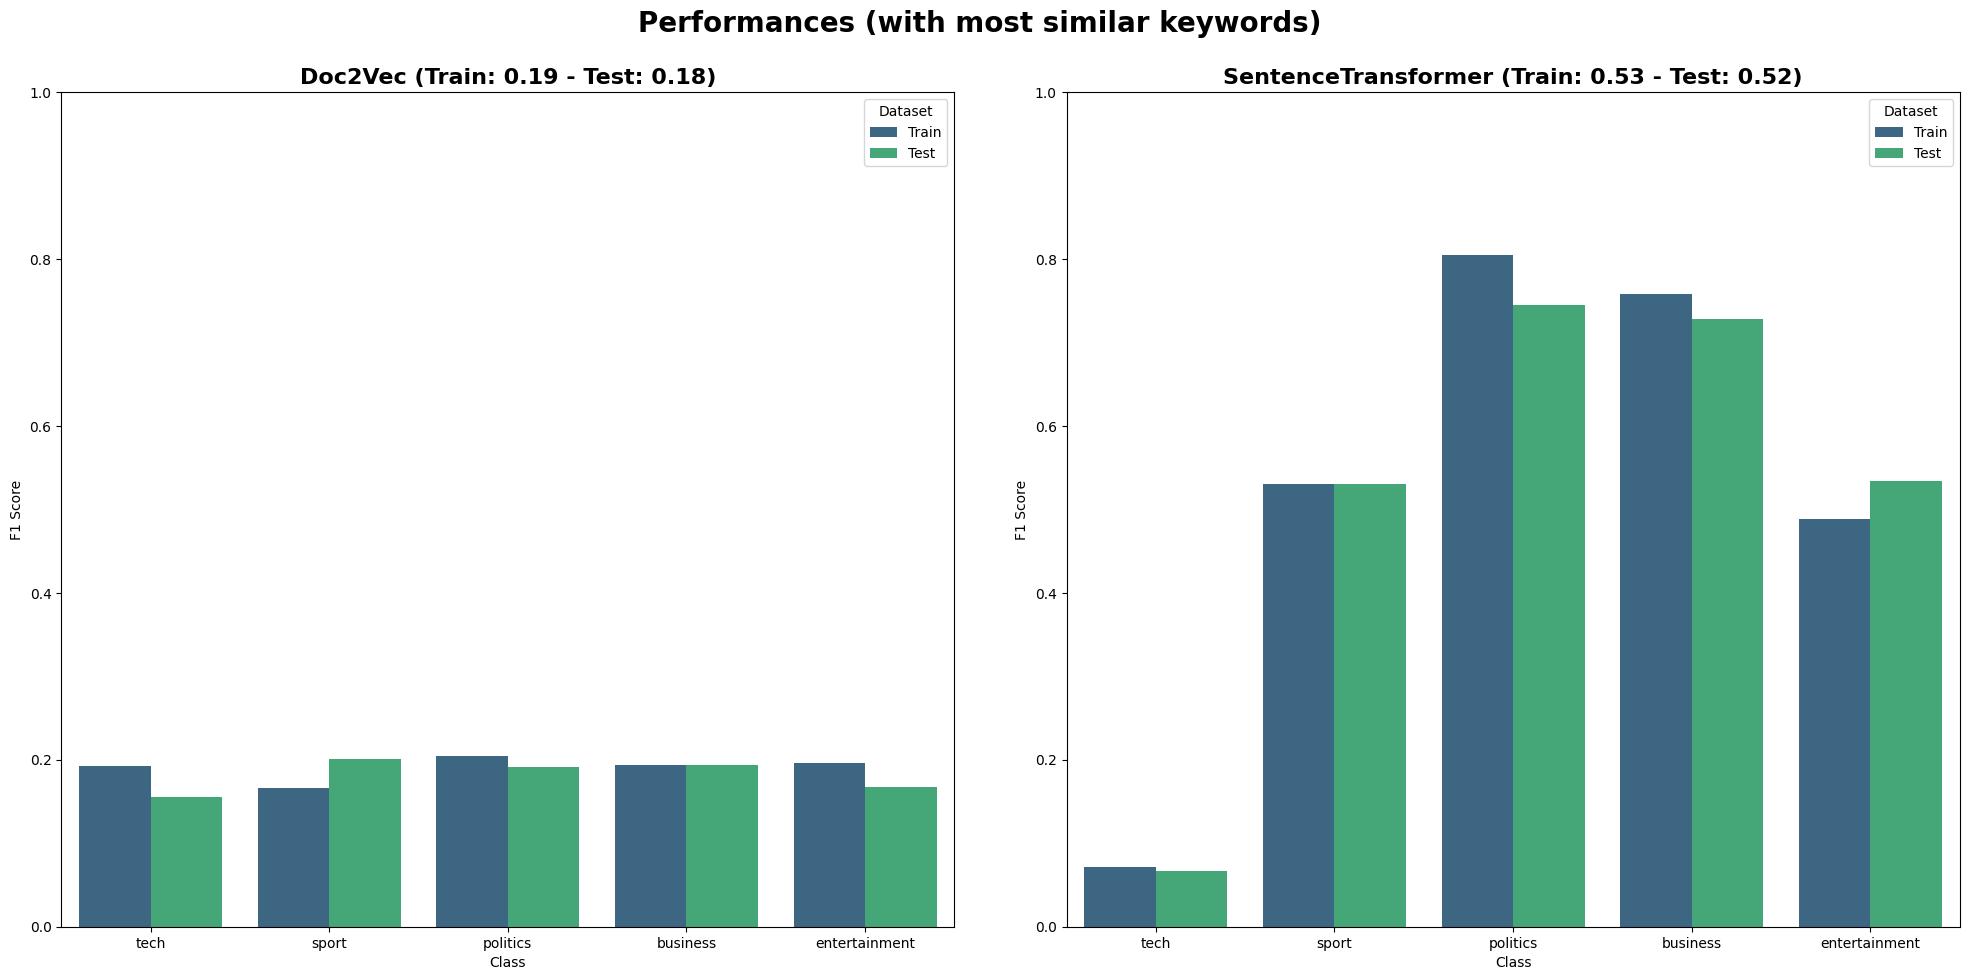

In [20]:
plot_performances_models(documents_df, most_similar_keywords, description='with most similar keywords')

# Performances with keywords extracted from supervised models

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

texts = documents_df['document'].tolist()
labels = documents_df['class_name'].tolist()

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

clf = LogisticRegression(random_state=0).fit(X, labels)

y_pred = clf.predict(X)

f1 = f1_score(labels, y_pred, average='micro')
print(f'F1 Score: {f1:.2f}')

F1 Score: 0.99


In [22]:
feature_names = vectorizer.get_feature_names_out()
coefs_by_class = clf.coef_

n_important_words_by_class = 100
most_important_words = {}

for i, class_label in enumerate(clf.classes_):
    class_coef = coefs_by_class[i]
    top_indices = sorted(range(len(class_coef)), key=lambda j: abs(class_coef[j]), reverse=True)[:n_important_words_by_class]
    important_words = [feature_names[idx] for idx in top_indices]
    most_important_words[class_label] = important_words

# display_keywords_as_df(most_important_words)

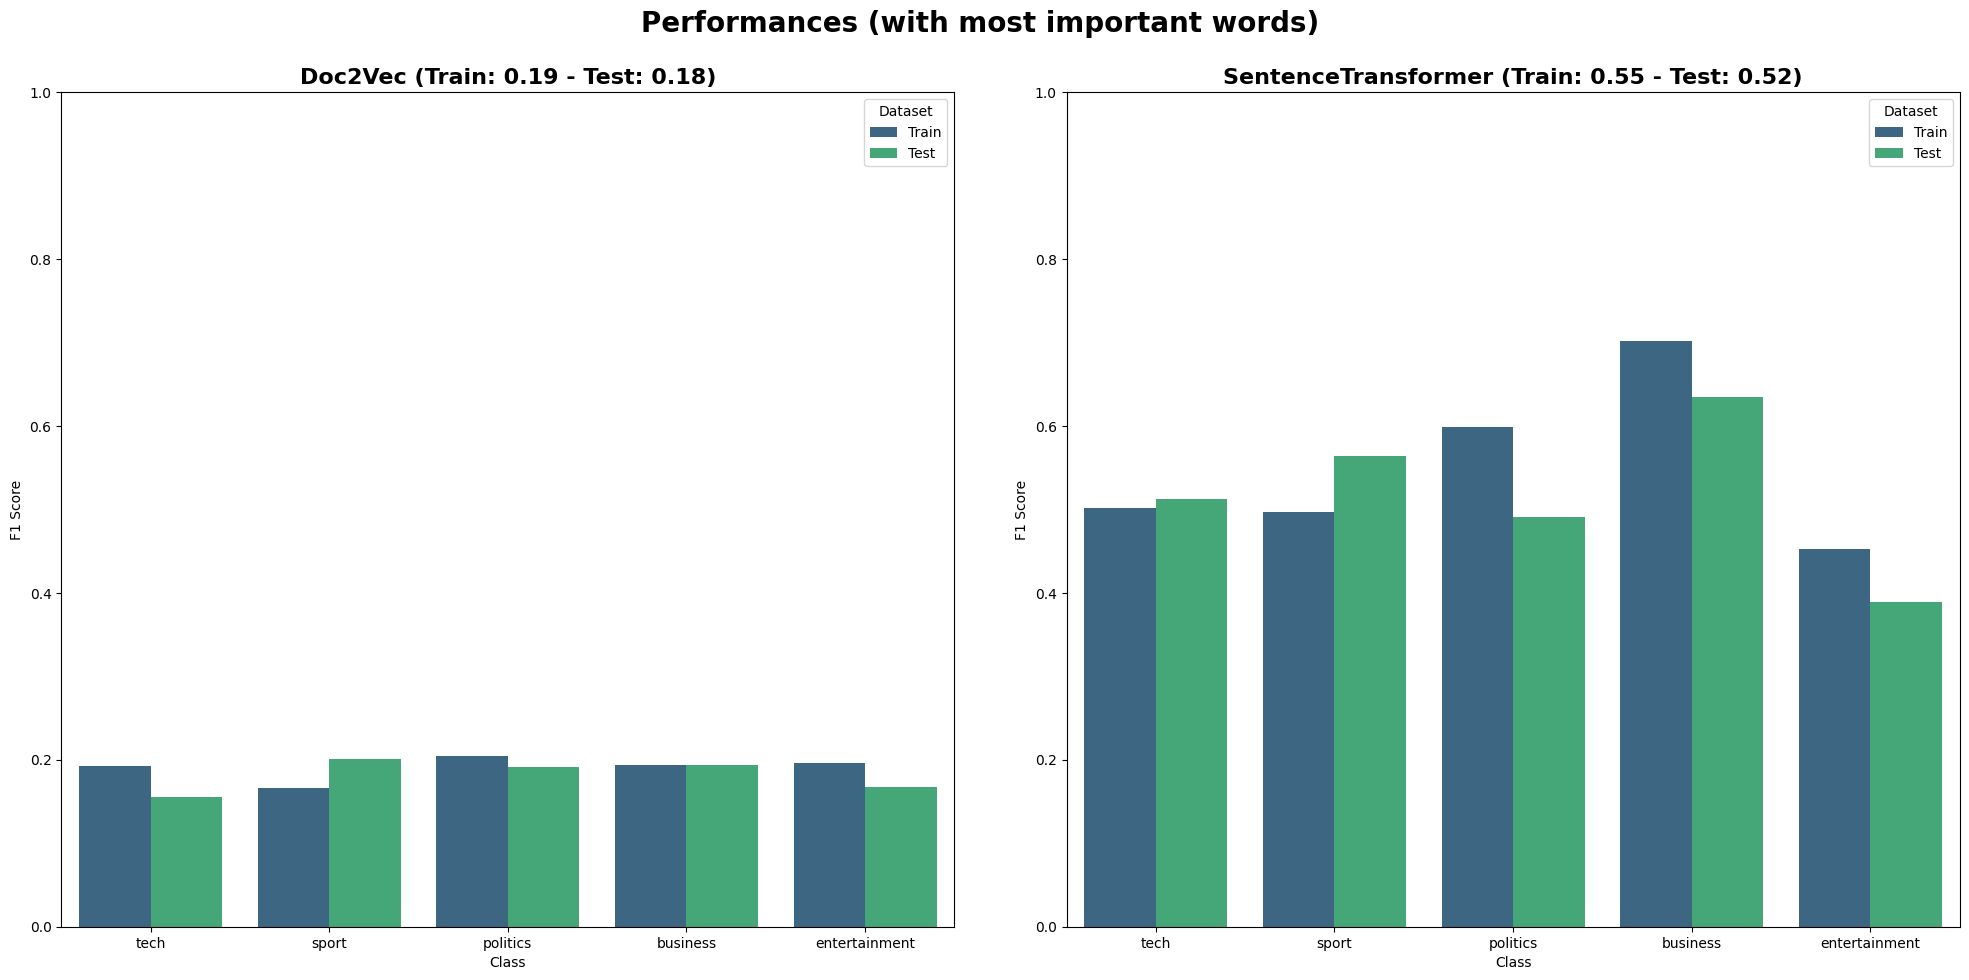

In [23]:
plot_performances_models(documents_df, most_important_words, description='with most important words')

# General performances

In [24]:
def get_f1_scores_for_dataset(dataset_name: str):
    """ Get the F1 scores for a dataset

    Args:
        dataset_name (str): Name of the dataset

    Returns:
        tuple: Tuple with the F1 scores for Doc2Vec and SentenceTransformer
    """
    documents_df = pd.read_csv(f'../../datasets/data/{dataset_name}/documents.csv')
    labels_df = pd.read_csv(f'../../datasets/data/{dataset_name}/labels.csv')

    train_docs = documents_df[documents_df['dataset_type'] == 'train']['document'].tolist()
    test_docs = documents_df[documents_df['dataset_type'] == 'test']['document'].tolist()

    train_labels = documents_df[documents_df['dataset_type'] == 'train']['class_name'].tolist()
    test_labels = documents_df[documents_df['dataset_type'] == 'test']['class_name'].tolist()

    train_docs = documents_df[documents_df['dataset_type'] == 'train']['document'].tolist()
    documents_repr = ''.join([item[0] for item in train_docs])[:10]

    load_cache = os.path.exists(f'../dacludek/cache/{documents_repr}_spacy_keywords.csv')
    print(f'Loading cache: {load_cache}')

    keywords_by_class = get_most_similar_keywords_by_class(10, documents_df, labels_df, load_cache=load_cache)

    # -- Doc2Vec
    doc2vec_model = DaCluDeK(defined_keywords=keywords_by_class, train_documents=train_docs, embedding_model_name='Doc2Vec', verbose=True, save_cache=True, load_cache=True, doc2vec_n_spacy_keywords=20)
    doc2vec_model.fit()

    y_pred_train = doc2vec_model.predict(train_docs)['class_name'].tolist()
    y_pred_test = doc2vec_model.predict(test_docs)['class_name'].tolist()

    f1_train = f1_score(train_labels, y_pred_train, average=None)
    f1_test = f1_score(test_labels, y_pred_test, average=None)

    doc2vec_avg_train, doc2vec_avg_test = np.mean(f1_train), np.mean(f1_test)

    # -- SentenceTransformer
    sentence_transformer_model = DaCluDeK(defined_keywords=keywords_by_class, train_documents=train_docs, embedding_model_name='SentenceTransformer', verbose=True)
    sentence_transformer_model.fit()

    y_pred_train = sentence_transformer_model.predict(train_docs)['class_name'].tolist()
    y_pred_test = sentence_transformer_model.predict(test_docs)['class_name'].tolist()

    f1_train = f1_score(train_labels, y_pred_train, average=None)
    f1_test = f1_score(test_labels, y_pred_test, average=None)

    sentence_transformer_avg_train, sentence_transformer_avg_test = np.mean(f1_train), np.mean(f1_test)

    return doc2vec_avg_train, doc2vec_avg_test, sentence_transformer_avg_train, sentence_transformer_avg_test

In [28]:
def get_performances_df_for_dataset(dataset_name: str, load: bool = False):
    if load:
        return pd.read_csv(f'./results/performances_df_{dataset_name.lower()}.csv')

    performances_df = pd.DataFrame(columns=['Dataset', 'Model', 'Train', 'Test'])

    labels_df = pd.read_csv(f'../../datasets/data/{dataset_name}/labels.csv')
    n_classes = len(labels_df['class_name'].unique())

    doc2vec_avg_train, doc2vec_avg_test, sentence_transformer_avg_train, sentence_transformer_avg_test = get_f1_scores_for_dataset(dataset_name)
    
    performances_df = pd.concat([performances_df, pd.DataFrame({
        'Dataset': [dataset_name, dataset_name], 
        'Model': ['Doc2Vec', 'SentenceTransformer'], 
        'Train': [doc2vec_avg_train, sentence_transformer_avg_train], 
        'Test': [doc2vec_avg_test, sentence_transformer_avg_test],
        'Random': [1 / n_classes] * 2
    })])

    performances_df.to_csv(f'./results/performances_df_{dataset_name.lower()}.csv')
    return performances_df

In [29]:
bbc_news_performances_df = get_performances_df_for_dataset('BBC_News', load=False)

Loading cache: True


In [39]:
twenty_news_groups_performances_df = get_performances_df_for_dataset('20NewsGroup', load=False)

Loading cache: True


In [42]:
dblp_performances_df = get_performances_df_for_dataset('DBLP', load=False)

Loading cache: True


In [43]:
m10_performances_df = get_performances_df_for_dataset('M10', load=False)

Loading cache: True


In [44]:
performances_df = pd.concat([
    bbc_news_performances_df, twenty_news_groups_performances_df, 
    dblp_performances_df, m10_performances_df
])

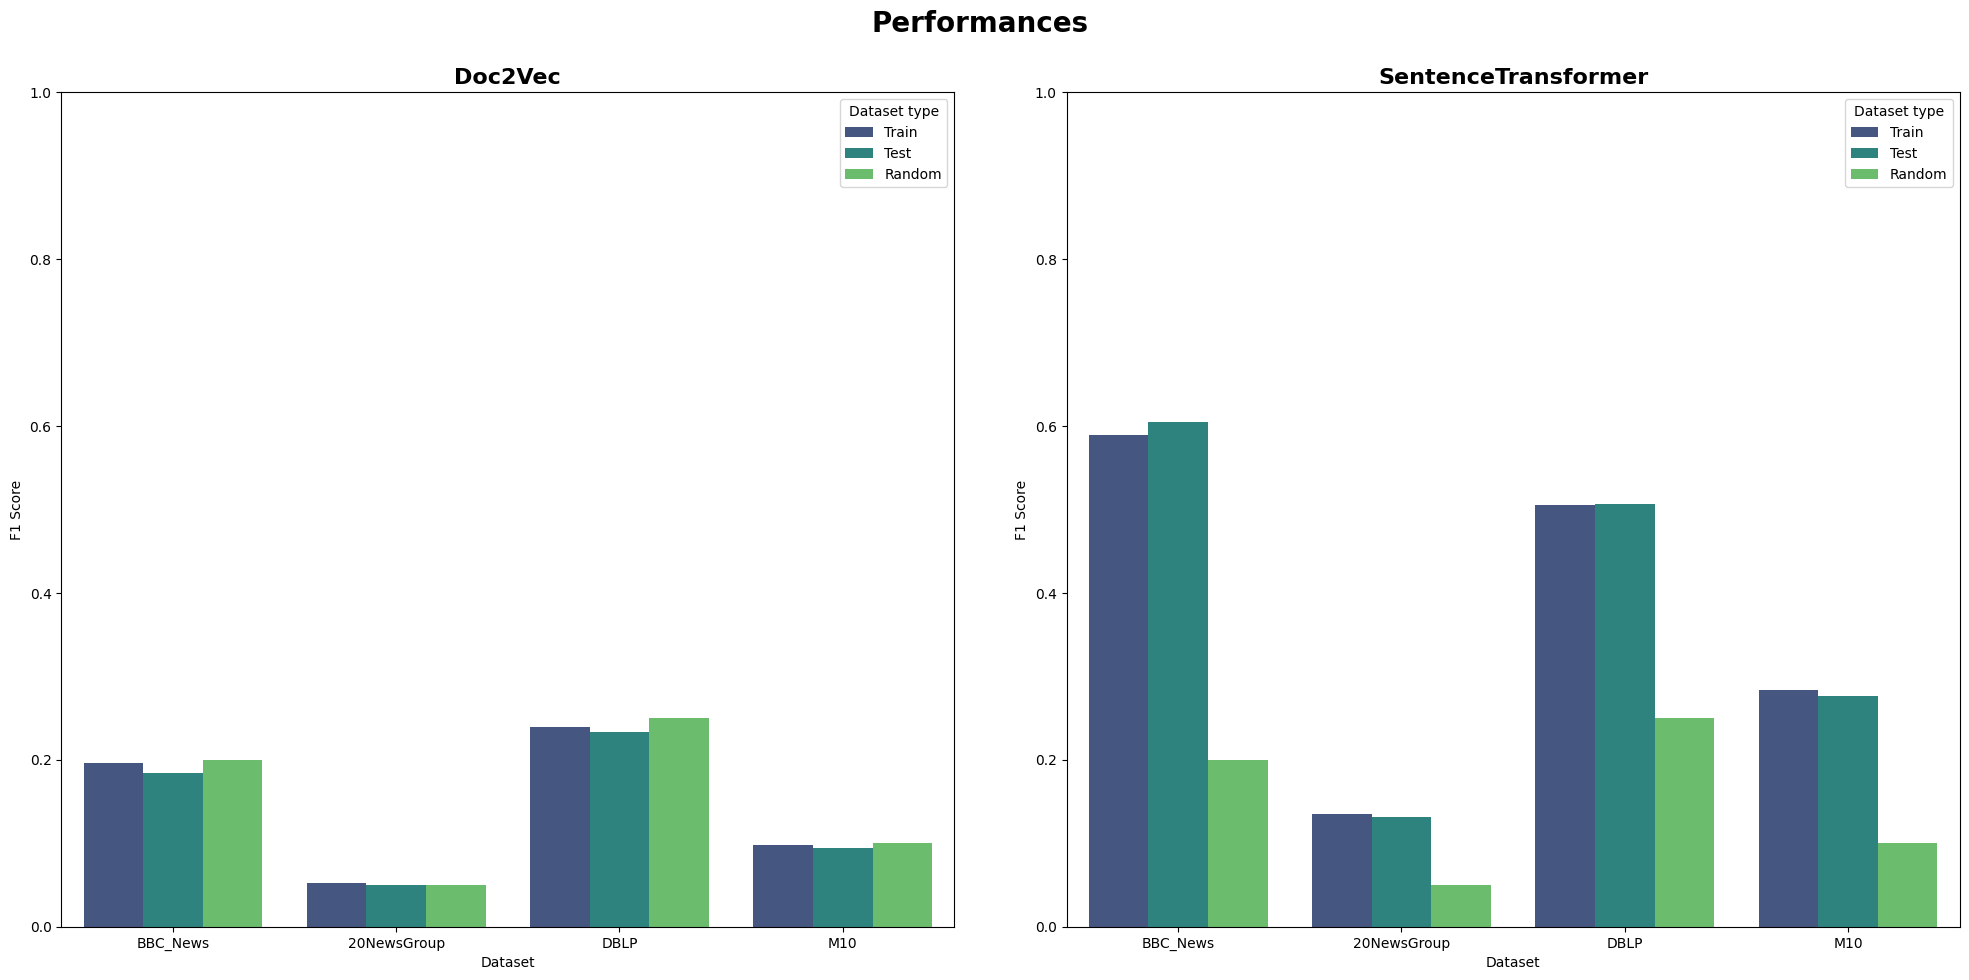

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Performances', fontsize=20, fontweight='bold')
fig.tight_layout(pad=5.0, rect=[-0.01, -0.03, 1.03, 1.07])

for i, model in enumerate(performances_df['Model'].unique()):
    modified_performances_df = pd.melt(performances_df[performances_df['Model'] == model], id_vars=['Dataset', 'Model'], value_vars=['Train', 'Test', 'Random'], var_name='Dataset type', value_name='F1 Score')

    sns.barplot(x='Dataset', y='F1 Score', hue='Dataset type', data=modified_performances_df, ax=ax[i], palette='viridis')
    ax[i].set_title(model, fontsize=16, fontweight='bold')
    ax[i].set_ylim(0, 1)

fig.savefig(f'../../figures/dacludek/general_performances.png')